<a href="https://colab.research.google.com/github/makuachteny/Add-to-cart-application/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Group Assignment
**Group Members**

John Deng Madit Akech

Makuach Teny Gatluak

Geofrey Tumwesigye

Peris Nyawira Wangui  


# Sentiment Analysis on IMDB Movie Reviews
# This notebook performs binary sentiment classification (positive/negative) using the IMDB 50K Movie Review Dataset.


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Loading the dataset
file_path = "content/IMDB Dataset.csv"
df = pd.read_csv(file_path, engine='python', on_bad_lines='warn')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Checking for empty strings
empty_reviews = (df['review'].str.strip() == '').sum()
empty_sentiments = (df['sentiment'].str.strip() == '').sum()
print(f"\nEmpty reviews: {empty_reviews}")
print(f"Empty sentiments: {empty_sentiments}")


Missing values per column:
 review       0
sentiment    0
dtype: int64

Empty reviews: 0
Empty sentiments: 0


### Missing values and empty strings handling
With the above codecell we checked for missing values and empty strings in both the `review` and `sentiment` columns to ensure that the dataset was clean.

**Results**:
- No missing values were found.
- No empty strings were detected.
- The dataset is complete and does not require dropping any rows.

# Exploratory Data Analysis (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<ipython-input-4-adc3e4fde0e7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


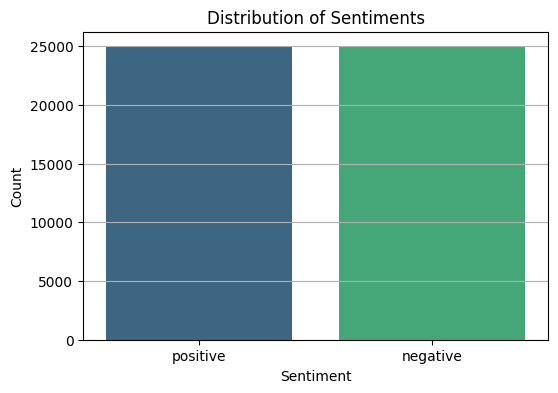

In [4]:
# Display dataset info & shape
df.info()
df.shape


# Checking class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


### Sentiment Distribution

The dataset is balanced, with an equal number of **positive** and **negative** reviews (25,000 each).There is no class imbalance.


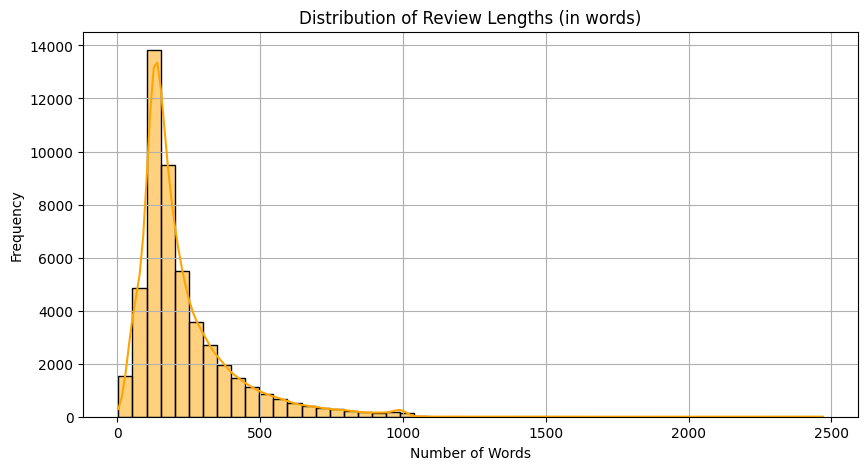

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


In [5]:
# Adding a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plott distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='orange')
plt.title("Distribution of Review Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid()
plt.show()

print(df['review_length'].describe())


### Review Length Distribution

Most reviews fall between 100 and 300 words. This insight helps us determine appropriate padding lengths when using neural networks and may inform choices around truncation or padding.

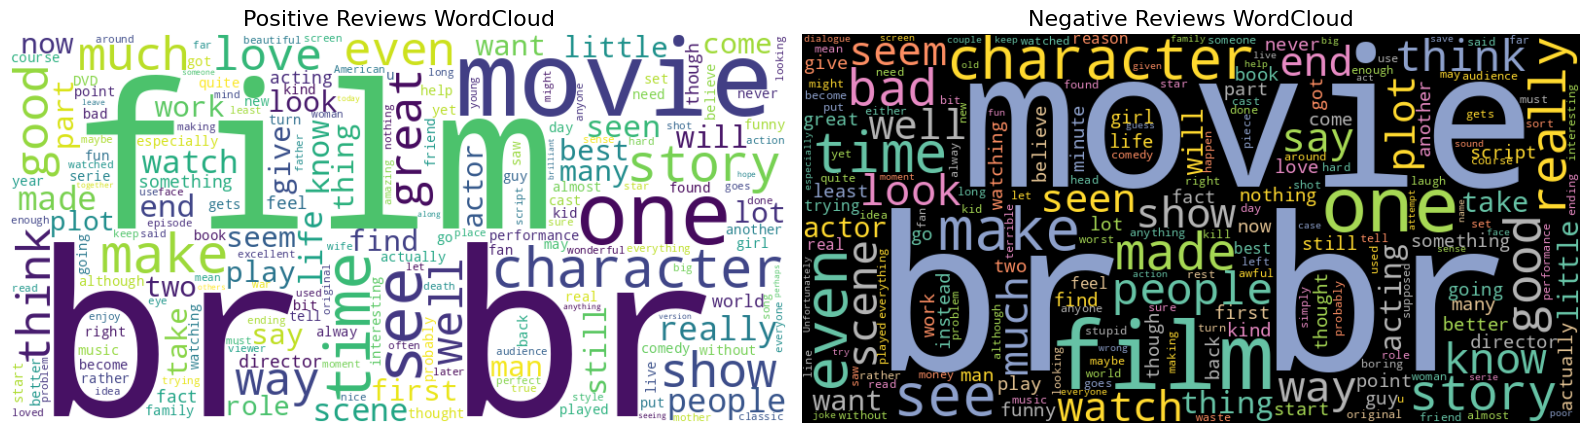

In [6]:
# Separating positive and negative reviews
pos_reviews = df[df['sentiment'] == 'positive']['review']
neg_reviews = df[df['sentiment'] == 'negative']['review']

# Generating Word Clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pos_reviews))
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(' '.join(neg_reviews))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(wordcloud_pos, interpolation='bilinear')
axs[0].set_title('Positive Reviews WordCloud', fontsize=16)
axs[0].axis('off')

axs[1].imshow(wordcloud_neg, interpolation='bilinear')
axs[1].set_title('Negative Reviews WordCloud', fontsize=16)
axs[1].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-7-911073b48375>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_df, palette='magma')


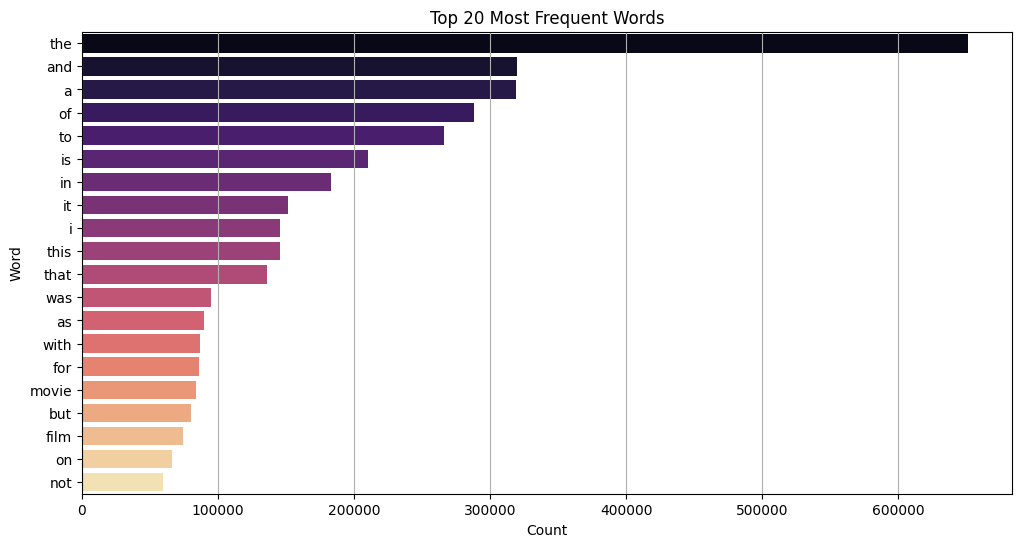

In [7]:
#  Most Common Words
# removing HTML tags & keeping only letters & spaces

from collections import Counter
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# Cleaning and tokenizing
df['cleaned'] = df['review'].apply(clean_text)
all_words = ' '.join(df['cleaned']).split()
word_counts = Counter(all_words)

# Getting 20 most common words
most_common_words = word_counts.most_common(20)

# Converting to DataFrame for plotting
common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=common_df, palette='magma')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.grid(axis='x')
plt.show()


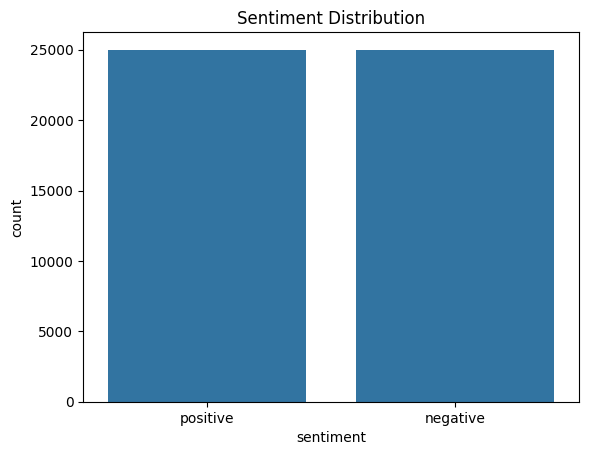

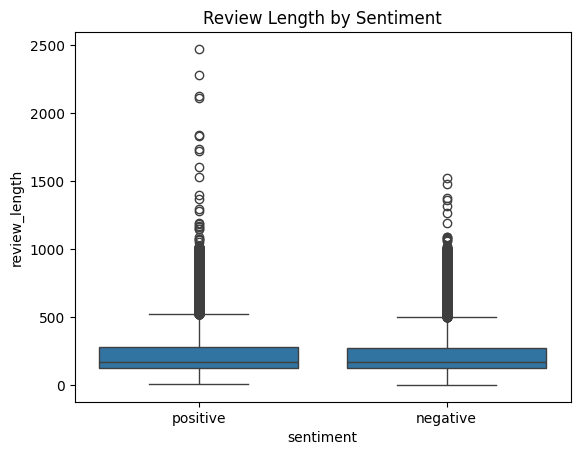

In [8]:
# Countplot of sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Boxplot of review lengths by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

# Text preprocessing & feature engineering



In [9]:
# Cleaning text, removing stopwords and preparing input features.

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [10]:
# Applying cleaning
import nltk

# Downloading the required resource
try:
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab')

# Cleaning the text function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

In [11]:
# Encoding labels and splitting data

df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
 # Model 1 – Logistic Regression with TF-IDF

 # TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
# Training the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [14]:
# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

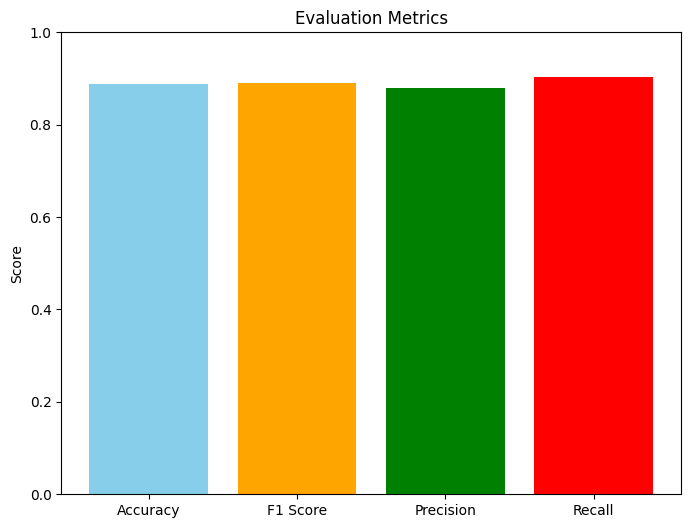

Accuracy: 0.8884
F1 Score: 0.8907168037602821
[[4336  625]
 [ 491 4548]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)

# Visualize the metrics using a bar plot
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

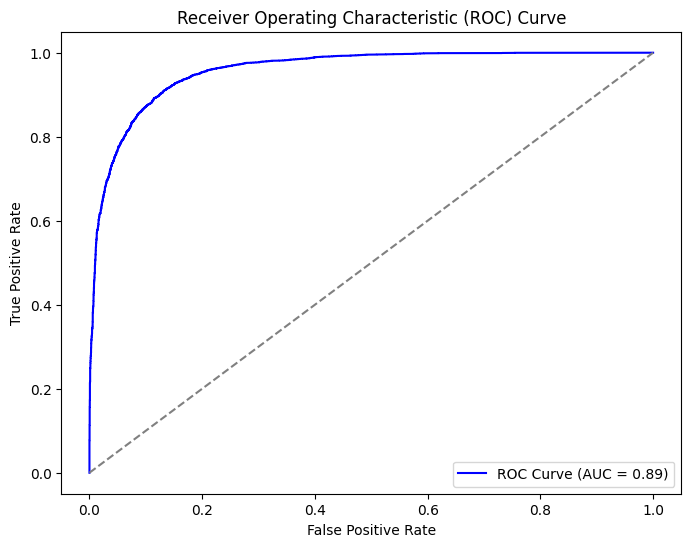

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_tfidf)[:, 1])
auc = roc_auc_score(y_test, y_pred_lr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

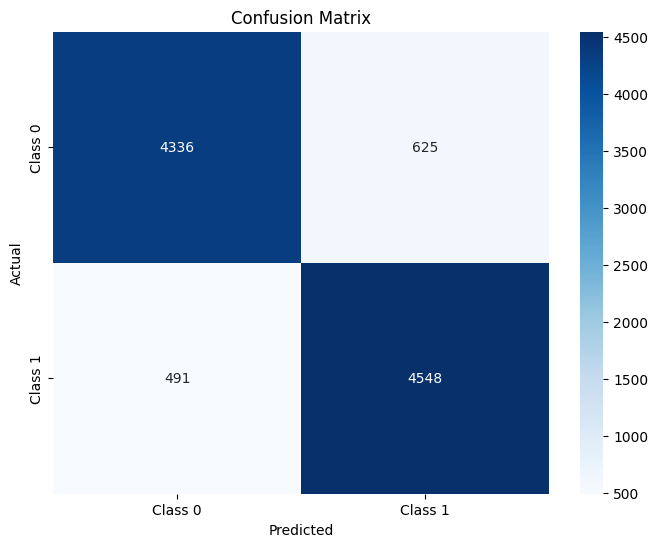

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Let's tune using GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [19]:
# Logistic Regression model
lr_model = LogisticRegression()

# Hyperparameter grid for GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],  # Solvers to try
    'penalty': ['l2', 'l1'],  # Regularization type
}

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fitting GridSearchCV on training data
grid_search.fit(X_train_tfidf, y_train)

# Printing the best parameters and best score
print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best Hyperparameters from GridSearchCV: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Cross-Validation Accuracy: 0.8862


In [20]:
# Get the best model
best_lr_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred_lr_tuned = best_lr_model.predict(X_test_tfidf)

# Metrics for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_lr_tuned)
f1_tuned = f1_score(y_test, y_pred_lr_tuned)
precision_tuned = precision_score(y_test, y_pred_lr_tuned)
recall_tuned = recall_score(y_test, y_pred_lr_tuned)

# Printing the evaluation metrics for the tuned model
print("\nTuned Model Evaluation:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")



Tuned Model Evaluation:
Accuracy: 0.8882
F1 Score: 0.8905
Precision: 0.8791
Recall: 0.9022


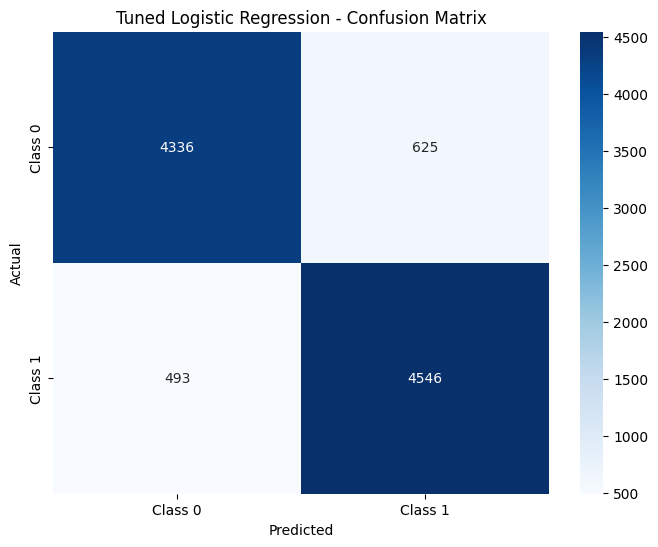

In [21]:
# Plotting confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



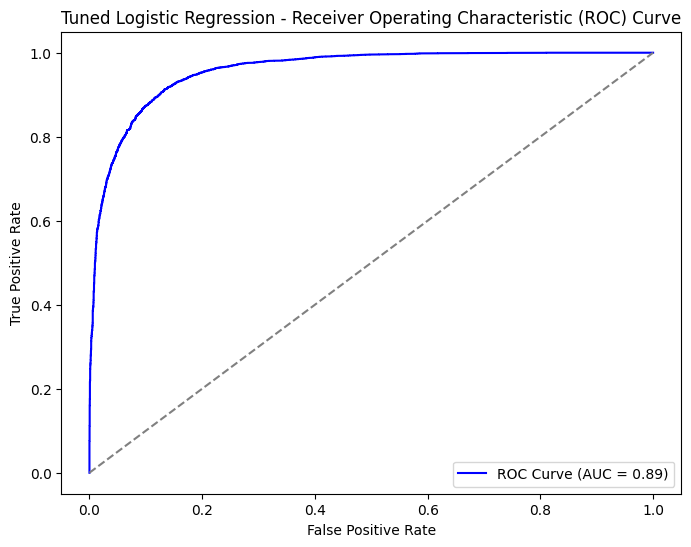

In [22]:
# ROC Curve
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, best_lr_model.predict_proba(X_test_tfidf)[:, 1])
auc_tuned = roc_auc_score(y_test, y_pred_lr_tuned)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='b', label='ROC Curve (AUC = %0.2f)' % auc_tuned)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Tuned Logistic Regression - Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_train_nb = nb_model.predict(X_train_tfidf)
y_pred_test_nb = nb_model.predict(X_test_tfidf)


Naive Bayes Model Evaluation
Training Accuracy: 0.864425
Testing Accuracy: 0.8534

Confusion Matrix:
[[4194  767]
 [ 699 4340]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4961
           1       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



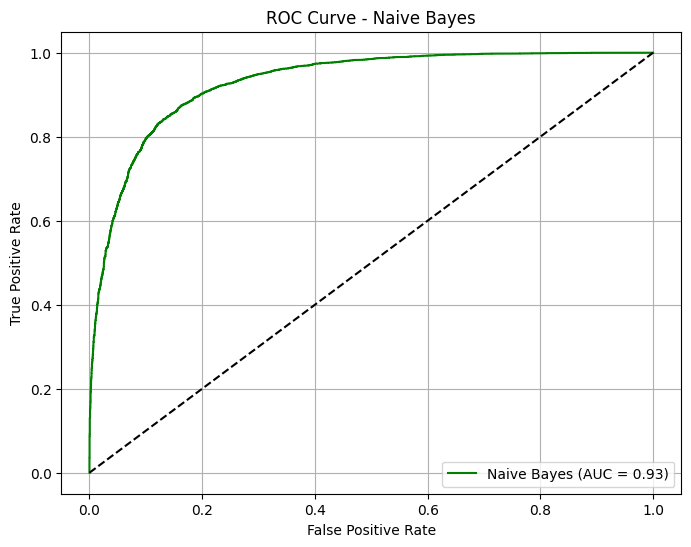

In [24]:
# Evaluation Metrics
print("Naive Bayes Model Evaluation")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_nb))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_nb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_nb))

# 4. ROC Curve and AUC
y_probs_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
auc_nb = roc_auc_score(y_test, y_probs_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Confusion Matrix:


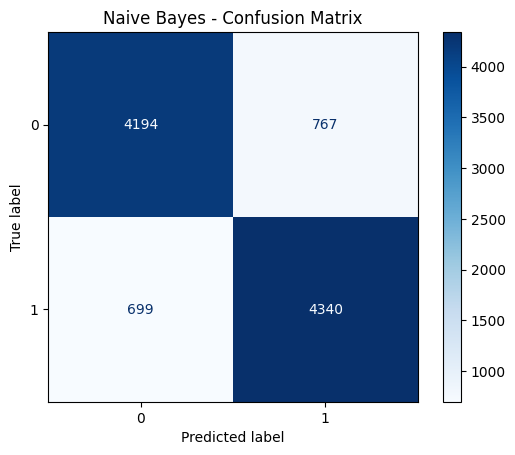

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

In [26]:
# Import the libraries
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [27]:
# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [28]:
# Hyperparameters for Adam optimizer
batch_size = 64
epochs = 20
dropout = 0.3
lstm_units = 64
learning_rate = 1e-3

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [29]:
# Building the model with Adam optimizer
model_adam = Sequential()
model_adam.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model_adam.add(LSTM(lstm_units, dropout=dropout, recurrent_dropout=dropout))
model_adam.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Compiling the model
model_adam.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Training the model
history_adam = model_adam.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 208ms/step - accuracy: 0.7567 - loss: 0.4906 - val_accuracy: 0.8512 - val_loss: 0.3402
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 202ms/step - accuracy: 0.8904 - loss: 0.2777 - val_accuracy: 0.8847 - val_loss: 0.2854
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 206ms/step - accuracy: 0.9121 - loss: 0.2298 - val_accuracy: 0.8728 - val_loss: 0.3138
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 196ms/step - accuracy: 0.9275 - loss: 0.1956 - val_accuracy: 0.8788 - val_loss: 0.3253
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.9415 - loss: 0.1588 - val_accuracy: 0.8772 - val_loss: 0.3361


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8824 - loss: 0.2886
Adam Optimizer - Test Accuracy: 0.8847, Loss: 0.2854


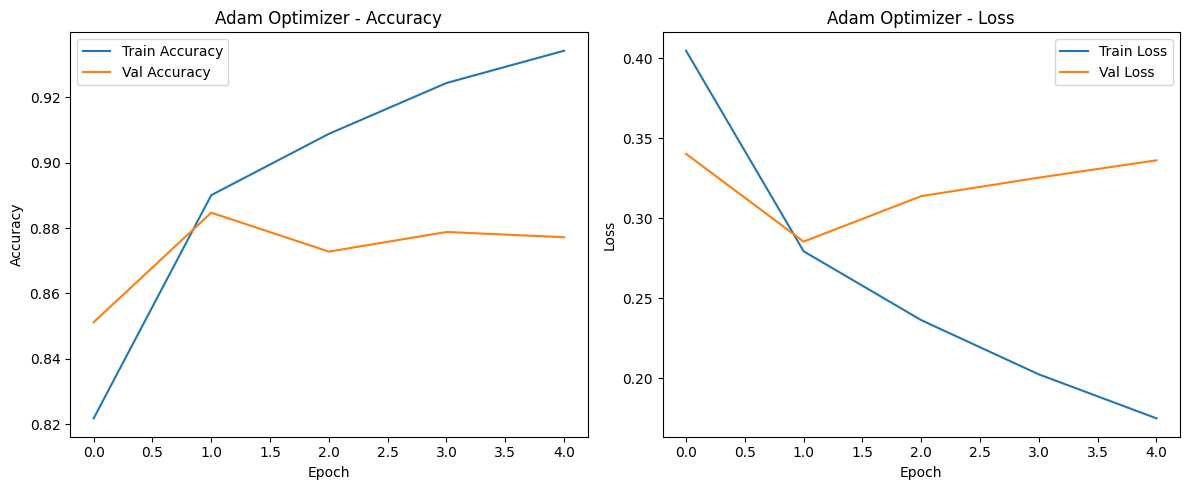

In [31]:
# Evaluating model performance
loss_adam, accuracy_adam = model_adam.evaluate(X_test_pad, y_test, verbose=1)
print(f"Adam Optimizer - Test Accuracy: {accuracy_adam:.4f}, Loss: {loss_adam:.4f}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_adam.history['val_accuracy'], label='Val Accuracy')
plt.title(f'Adam Optimizer - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title(f'Adam Optimizer - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting probabilities for ROC AUC
y_pred_prob_adam = model_adam.predict(X_test_pad, verbose=0)

# Converting probabilities to binary class predictions
y_pred_adam = (y_pred_prob_adam > 0.5).astype(int)

# Evaluating using Accuracy and Loss
loss_adam, accuracy_adam = model_adam.evaluate(X_test_pad, y_test, verbose=0)
print(f"Adam Optimizer - Test Accuracy: {accuracy_adam:.4f}, Loss: {loss_adam:.4f}")

# Precision, Recall, F1-Score
precision_adam = precision_score(y_test, y_pred_adam)
recall_adam = recall_score(y_test, y_pred_adam)
f1_adam = f1_score(y_test, y_pred_adam)

# Print precision, recall, F1-score
print(f"Adam Optimizer - Precision: {precision_adam:.4f}")
print(f"Adam Optimizer - Recall: {recall_adam:.4f}")
print(f"Adam Optimizer - F1-Score: {f1_adam:.4f}")

Adam Optimizer - Test Accuracy: 0.8847, Loss: 0.2854
Adam Optimizer - Precision: 0.8752
Adam Optimizer - Recall: 0.8994
Adam Optimizer - F1-Score: 0.8871


Adam Optimizer - ROC AUC: 0.9516


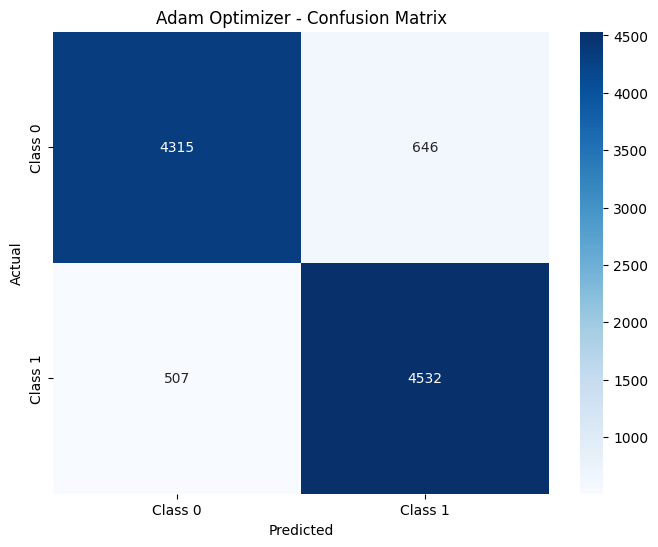

In [33]:
# ROC AUC score
roc_auc_adam = roc_auc_score(y_test, y_pred_prob_adam)
print(f"Adam Optimizer - ROC AUC: {roc_auc_adam:.4f}")

# Confusion Matrix
cm_adam = confusion_matrix(y_test, y_pred_adam)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adam, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Adam Optimizer - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

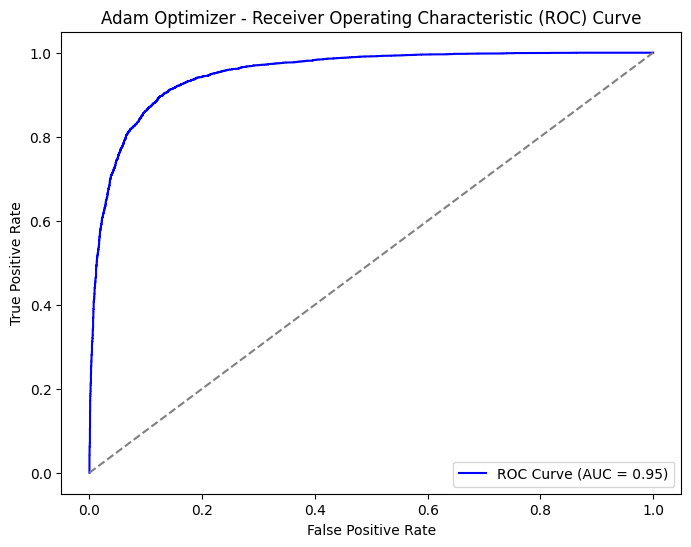

In [34]:
# Plotting ROC Curve
fpr_adam, tpr_adam, _ = roc_curve(y_test, y_pred_prob_adam)
plt.figure(figsize=(8, 6))
plt.plot(fpr_adam, tpr_adam, color='b', label='ROC Curve (AUC = %0.2f)' % roc_auc_adam)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Adam Optimizer - Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [35]:
from keras.optimizers import RMSprop

# Hyperparameters for RMSprop optimizer
learning_rate_rmsprop = 1e-3

# Building the model with RMSprop optimizer
model_rmsprop = Sequential()
model_rmsprop.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model_rmsprop.add(LSTM(lstm_units, dropout=dropout, recurrent_dropout=dropout))
model_rmsprop.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
# Compiling the model
model_rmsprop.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=learning_rate_rmsprop), metrics=['accuracy'])

# Training the model
history_rmsprop = model_rmsprop.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 196ms/step - accuracy: 0.7326 - loss: 0.5142 - val_accuracy: 0.8702 - val_loss: 0.3045
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.8831 - loss: 0.3001 - val_accuracy: 0.8724 - val_loss: 0.2970
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 203ms/step - accuracy: 0.8994 - loss: 0.2638 - val_accuracy: 0.8830 - val_loss: 0.2875
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.9094 - loss: 0.2326 - val_accuracy: 0.8860 - val_loss: 0.2839
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 200ms/step - accuracy: 0.9161 - loss: 0.2224 - val_accuracy: 0.8901 - val_loss: 0.2913
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 197ms/step - accuracy: 0.9236 - loss: 0.2037 - val_accuracy: 0.8908 - val_loss: 0.2758
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 199ms/step - accuracy: 0.9297 - loss: 0.1887 - val_accuracy: 0.8868 - val_loss: 0.2768
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.9344 -

RMSprop Optimizer - Test Accuracy: 0.8908, Loss: 0.2758


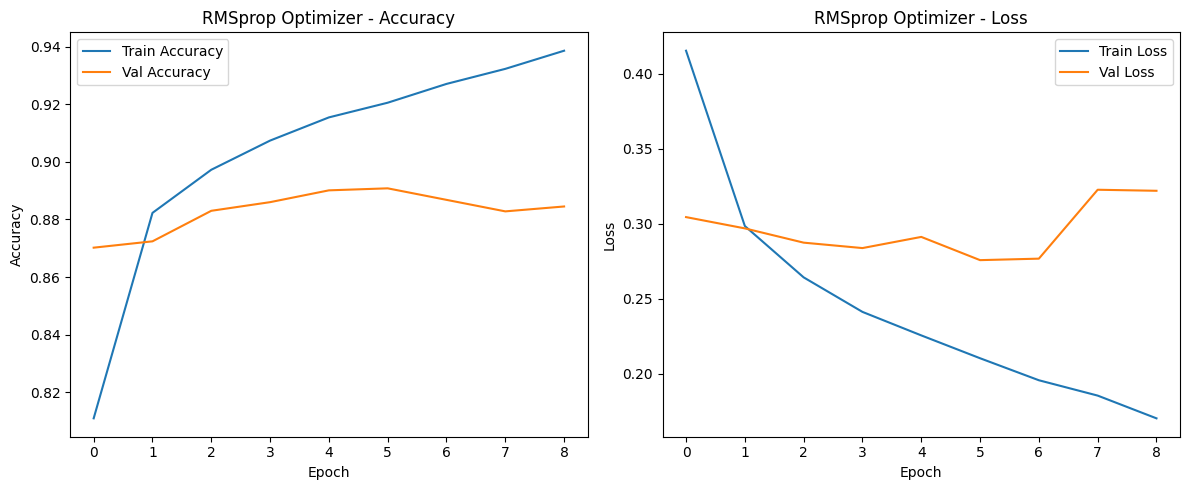

In [41]:
# Evaluating the model performance
loss_rmsprop, accuracy_rmsprop = model_rmsprop.evaluate(X_test_pad, y_test, verbose=0)
print(f"RMSprop Optimizer - Test Accuracy: {accuracy_rmsprop:.4f}, Loss: {loss_rmsprop:.4f}")

# Plotting accuracy and loss for RMSprop
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_rmsprop.history['accuracy'], label='Train Accuracy')
plt.plot(history_rmsprop.history['val_accuracy'], label='Val Accuracy')
plt.title(f'RMSprop Optimizer - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_rmsprop.history['loss'], label='Train Loss')
plt.plot(history_rmsprop.history['val_loss'], label='Val Loss')
plt.title(f'RMSprop Optimizer - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Predicting probabilities for ROC AUC
y_pred_prob_rmsprop = model_rmsprop.predict(X_test_pad, verbose=0)

# Converting probabilities to binary class predictions
y_pred_rmsprop = (y_pred_prob_rmsprop > 0.5).astype(int)

# Evaluate using Accuracy and Loss (already done during training)
loss_rmsprop, accuracy_rmsprop = model_rmsprop.evaluate(X_test_pad, y_test, verbose=1)
print(f"RMSprop Optimizer - Test Accuracy: {accuracy_rmsprop:.4f}, Loss: {loss_rmsprop:.4f}")

# Precision, Recall, F1-Score
precision_rmsprop = precision_score(y_test, y_pred_rmsprop)
recall_rmsprop = recall_score(y_test, y_pred_rmsprop)
f1_rmsprop = f1_score(y_test, y_pred_rmsprop)

# Print precision, recall, F1-score
print(f"RMSprop Optimizer - Precision: {precision_rmsprop:.4f}")
print(f"RMSprop Optimizer - Recall: {recall_rmsprop:.4f}")
print(f"RMSprop Optimizer - F1-Score: {f1_rmsprop:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8876 - loss: 0.2749
RMSprop Optimizer - Test Accuracy: 0.8908, Loss: 0.2758
RMSprop Optimizer - Precision: 0.8884
RMSprop Optimizer - Recall: 0.8958
RMSprop Optimizer - F1-Score: 0.8921


RMSprop Optimizer - ROC AUC: 0.9566


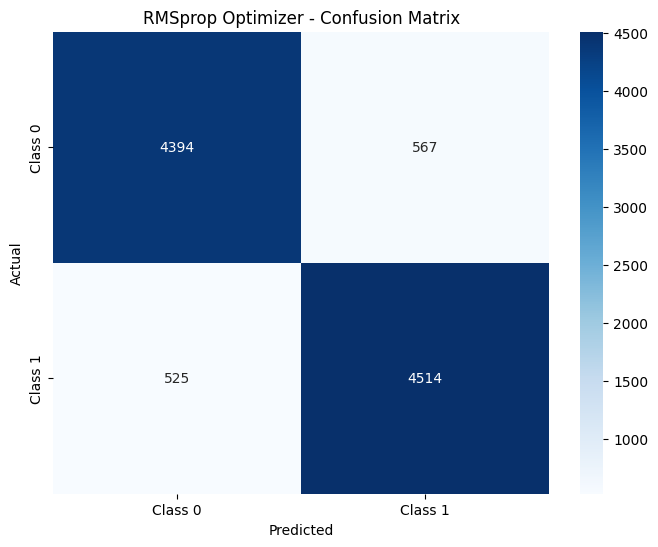

In [43]:
# ROC AUC score
roc_auc_rmsprop = roc_auc_score(y_test, y_pred_prob_rmsprop)
print(f"RMSprop Optimizer - ROC AUC: {roc_auc_rmsprop:.4f}")

# Confusion Matrix
cm_rmsprop = confusion_matrix(y_test, y_pred_rmsprop)

# Plotting Confusion Matrix for RMSprop
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rmsprop, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("RMSprop Optimizer - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

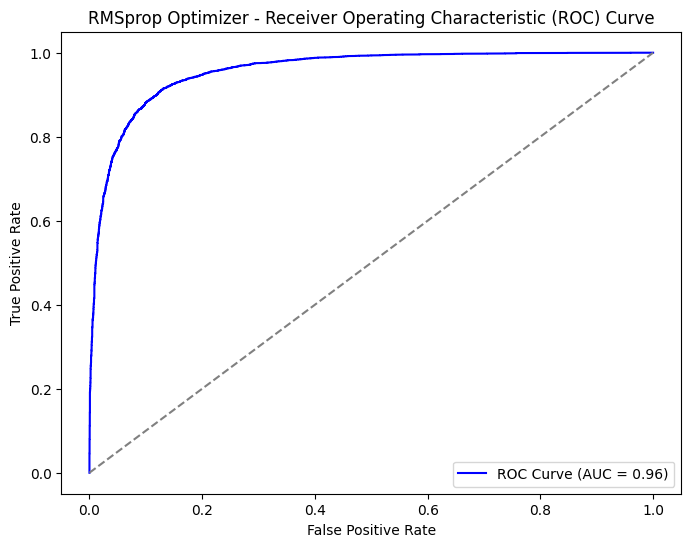

In [44]:
# Plotting ROC Curve for RMSprop
fpr_rmsprop, tpr_rmsprop, _ = roc_curve(y_test, y_pred_prob_rmsprop)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rmsprop, tpr_rmsprop, color='b', label='ROC Curve (AUC = %0.2f)' % roc_auc_rmsprop)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('RMSprop Optimizer - Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

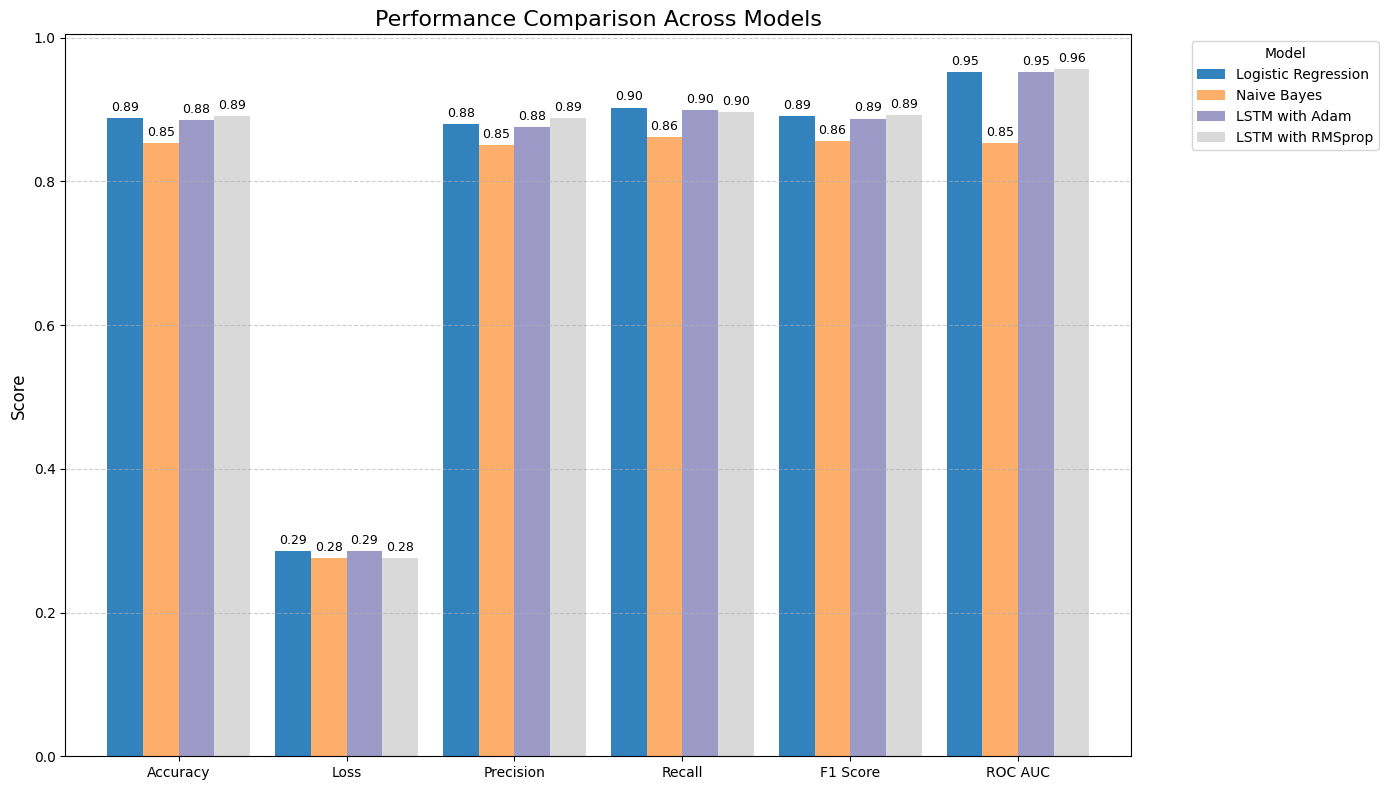

In [58]:
# Comparing the models' accuracy and loss


# Data (unchanged, assumes all metrics already defined)
results = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'LSTM with Adam', 'LSTM with RMSprop'],
    'Accuracy': [accuracy, accuracy_score(y_test, y_pred_test_nb), accuracy_adam, accuracy_rmsprop],
    'Loss': [loss_adam, loss_rmsprop, loss_adam, loss_rmsprop],
    'Precision': [precision, precision_score(y_test, y_pred_test_nb), precision_adam, precision_rmsprop],
    'Recall': [recall, recall_score(y_test, y_pred_test_nb), recall_adam, recall_rmsprop],
    'F1 Score': [f1, f1_score(y_test, y_pred_test_nb), f1_adam, f1_rmsprop],
    'ROC AUC': [roc_auc_adam, roc_auc_score(y_test, y_pred_test_nb), roc_auc_adam, roc_auc_rmsprop]
}

# Convert to DataFrame
results_df = pd.DataFrame(results).set_index('Model')

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Transpose to plot metrics as groups for each model
results_df.T.plot(kind='bar', ax=ax, colormap='tab20c', width=0.85)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

# Customize the plot
plt.title('Performance Comparison Across Models', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()
